In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

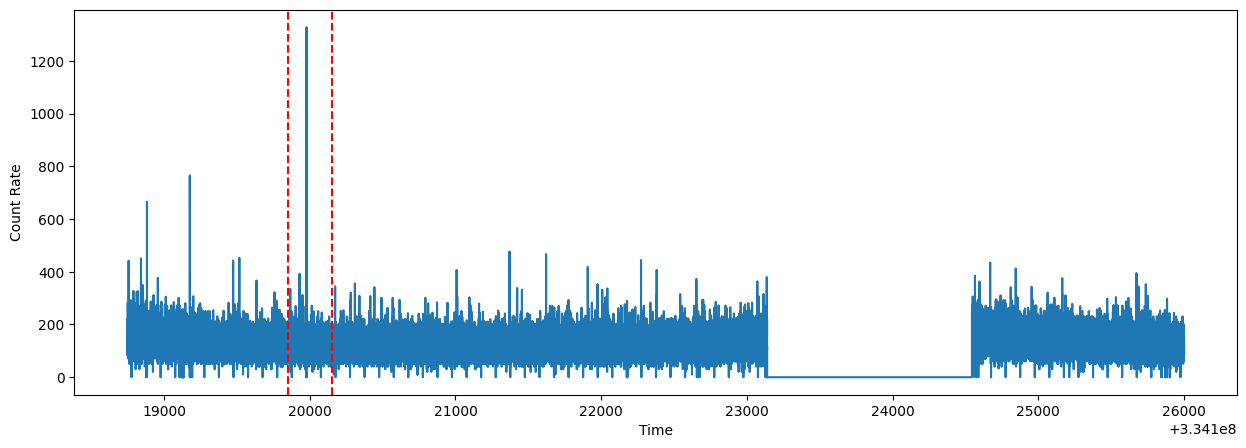

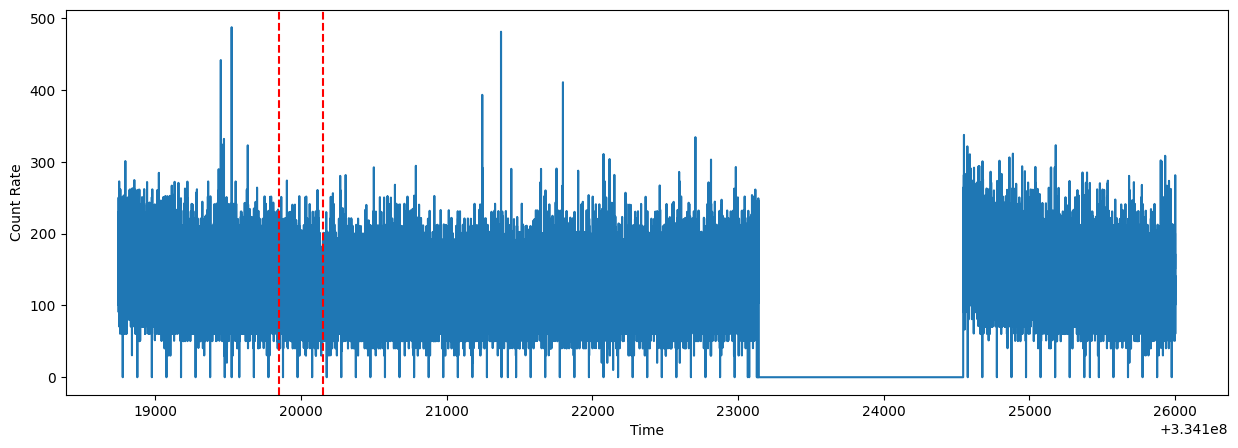

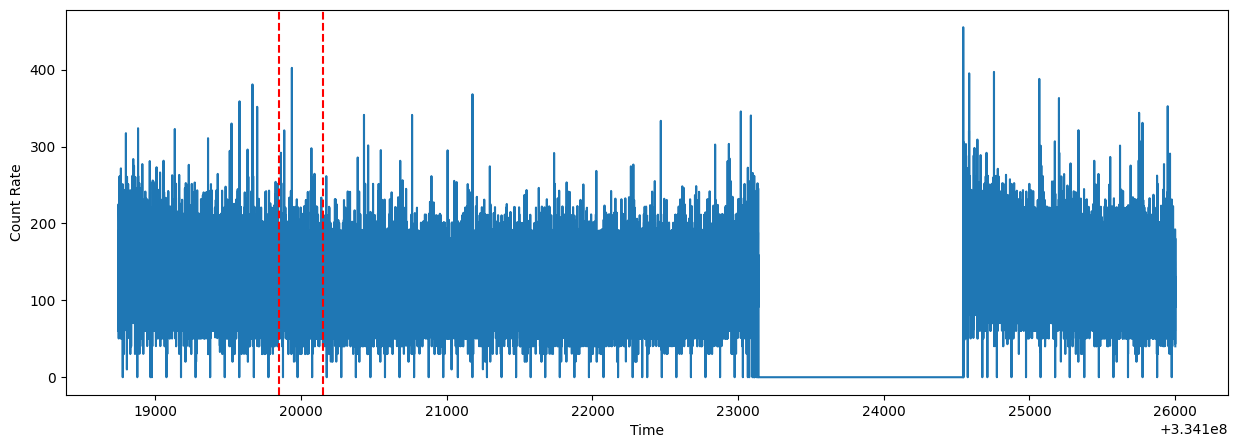

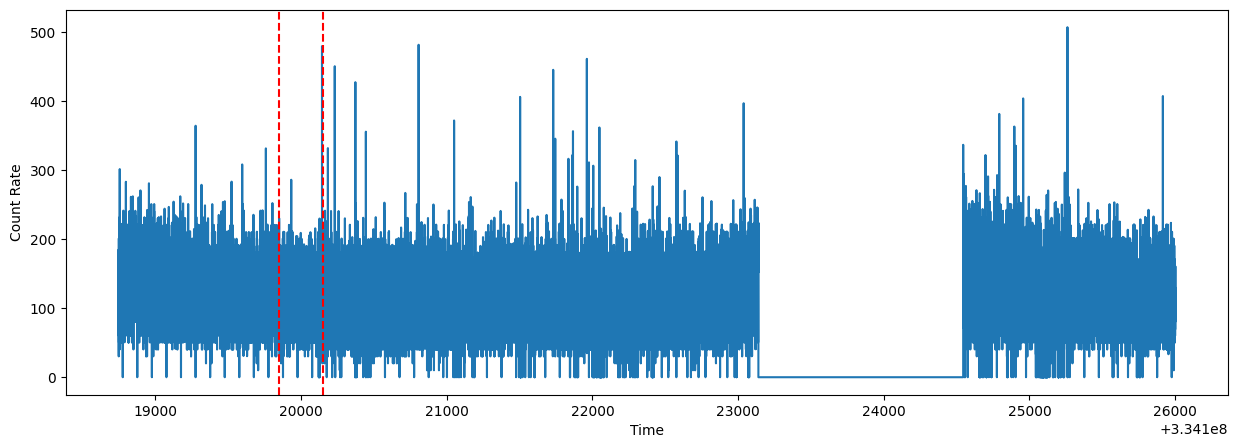

In [21]:
m1=fits.open('final_output_Q0.lc')
m2=fits.open('final_output_Q1.lc')
m3=fits.open('final_output_Q2.lc')
m4=fits.open('final_output_Q3.lc')
req1 = 19850 + 3.341e8
req2 = 20150 + 3.341e8
m_complete = [m1,m2,m3,m4]
a1 = m1
a2 = m2
a3 = m3
a4 = m4
for m in m_complete:
    plt.subplots(1, 1, figsize = (15,5))
    plt.plot(m[1].data['TIME'],m[1].data['RATE'])
    plt.xlabel("Time")
    plt.axvline(x=req1, color='r', linestyle='--')
    plt.axvline(x=req2, color='r', linestyle='--')
    plt.ylabel("Count Rate")


### Calculating mean of the background of the GRB.


In [4]:
x_ranges = [[18870, 22990], [24700, 26000]]
for m in m_complete:
    x = m[1].data['TIME']
    y = m[1].data['RATE']
    c = 33410e4
    mean_values = []
    for x_range in x_ranges:
        indices = np.where((x - c >= x_range[0]) & (x - c <= x_range[1]))
        y_range = y[indices]
        mean = np.mean(y_range)
        mean_values.append(mean)
    indices_range = np.where((x - c >= 2300) & (x - c <= 2500))
    y[indices_range] -= (mean_values[0]+mean_values[1])/2
print((mean_values[0]+mean_values[1])/2)

115.34901428222656


## Using the median filter to detrend the lightcurve:
### Detrending pre-grb portion. 

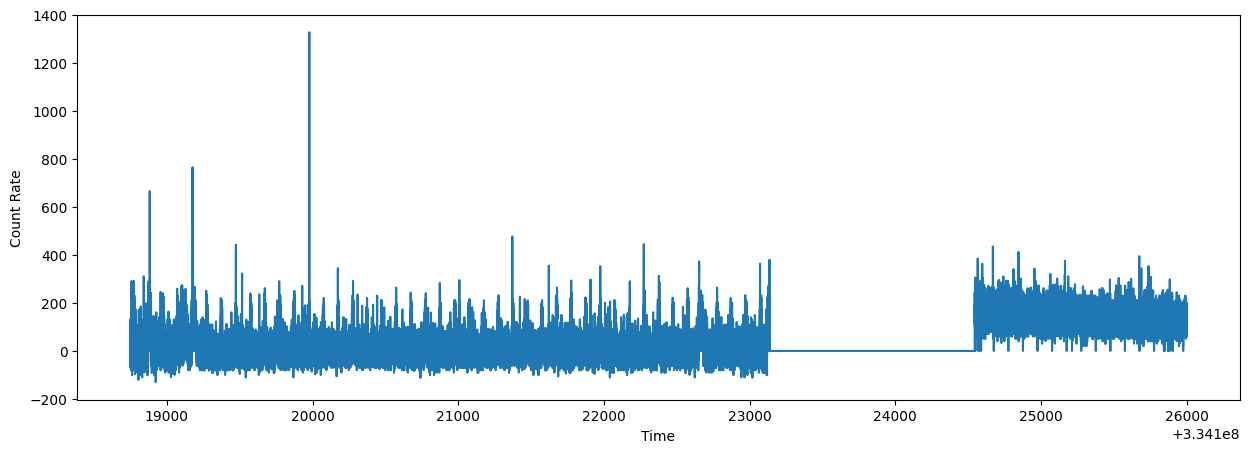

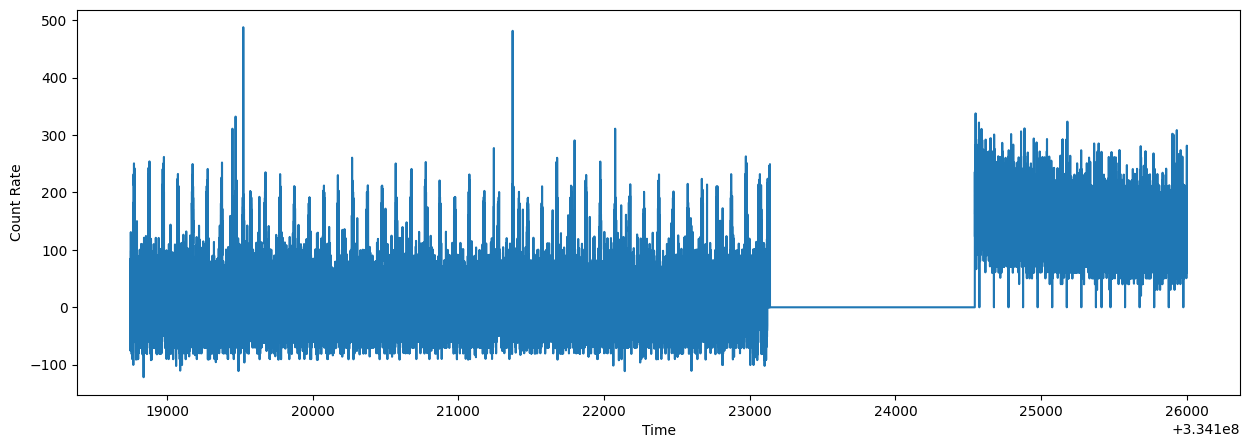

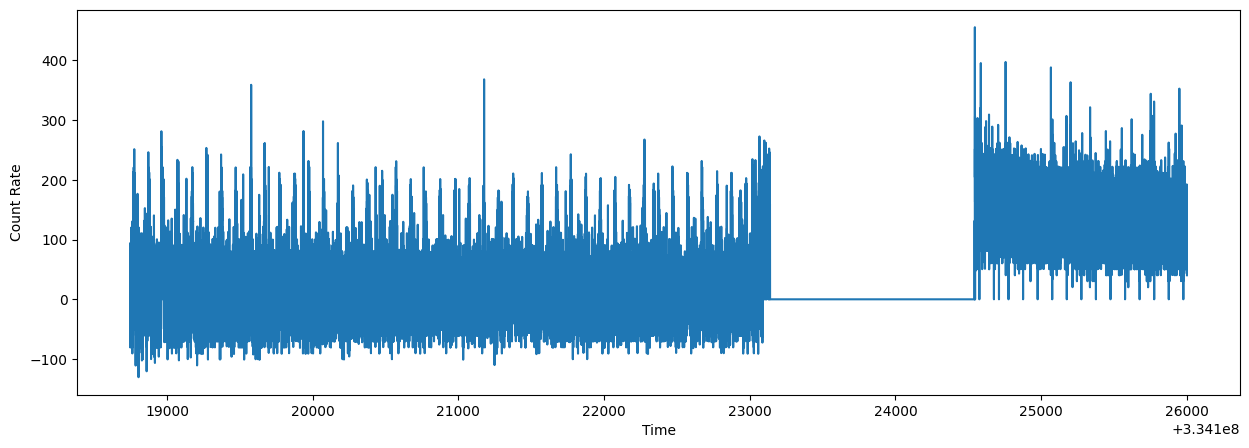

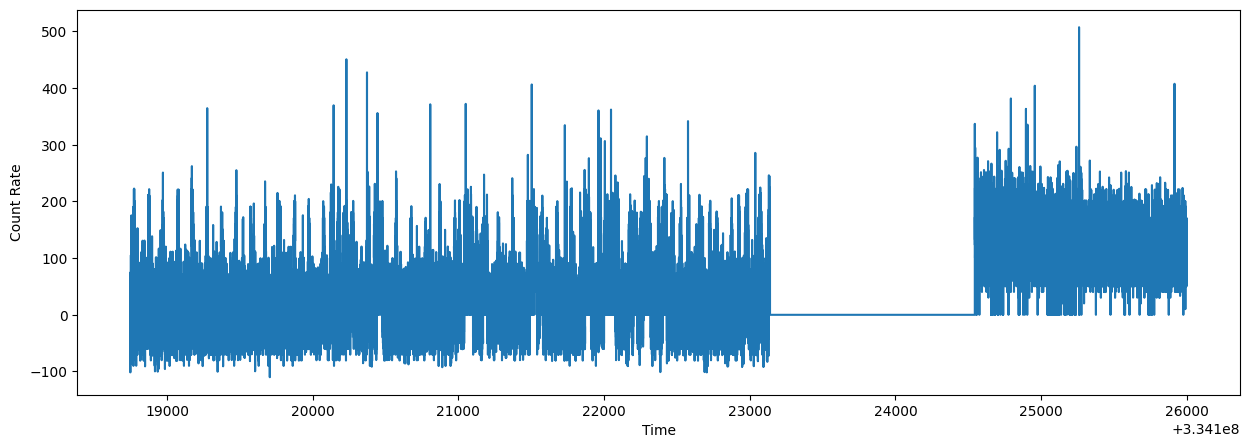

In [5]:
for m in m_complete:
    x = m[1].data['TIME']
    y = m[1].data['RATE']
    c = 33410e4
    intervals = np.arange(18740, 23140, 10)

    median_values = []

    for i in range(len(intervals) - 1 ):
        indices = np.where((x - c >= intervals[i]) & (x - c < intervals[i + 1]))
        y_interval = y[indices]
        if(y_interval.min()==0):
            continue
        median = np.median(y_interval)
        median_values.append(median)
        y[indices] -= median
    plt.subplots(1, 1, figsize = (15,5))
    plt.xlabel("Time")
    plt.ylabel("Count Rate")
    plt.plot(x,y)


### Detrending post-grb portion.


c:\Users\yashs\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yashs\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


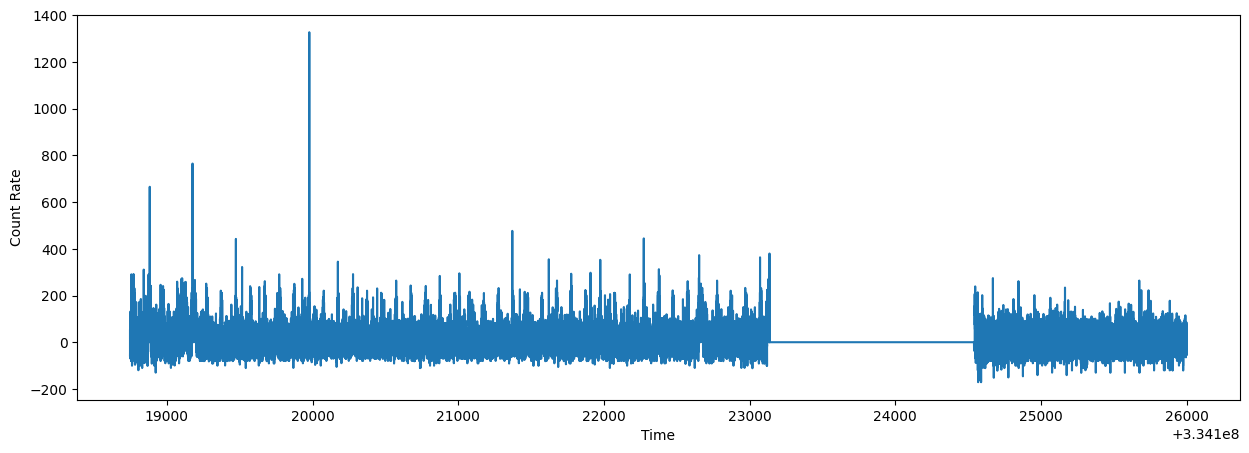

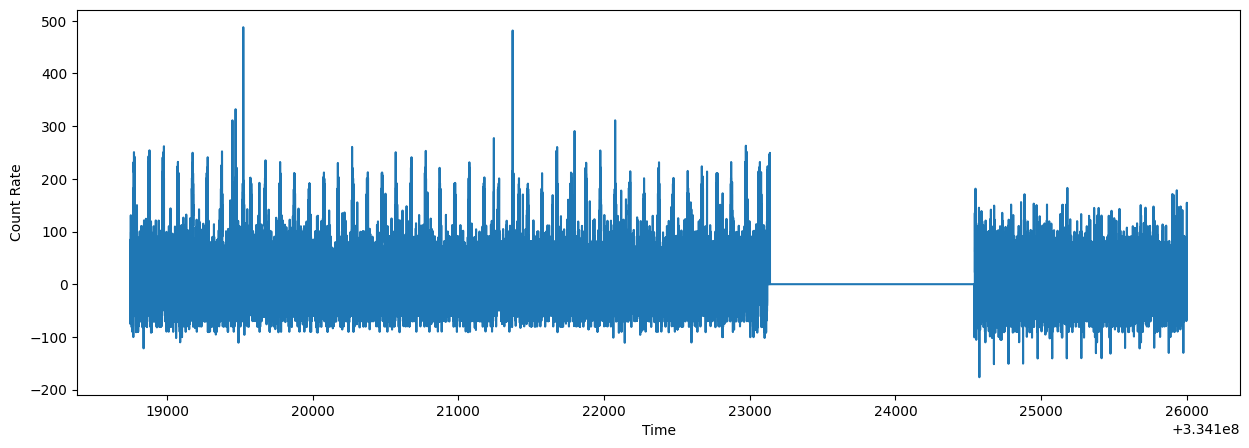

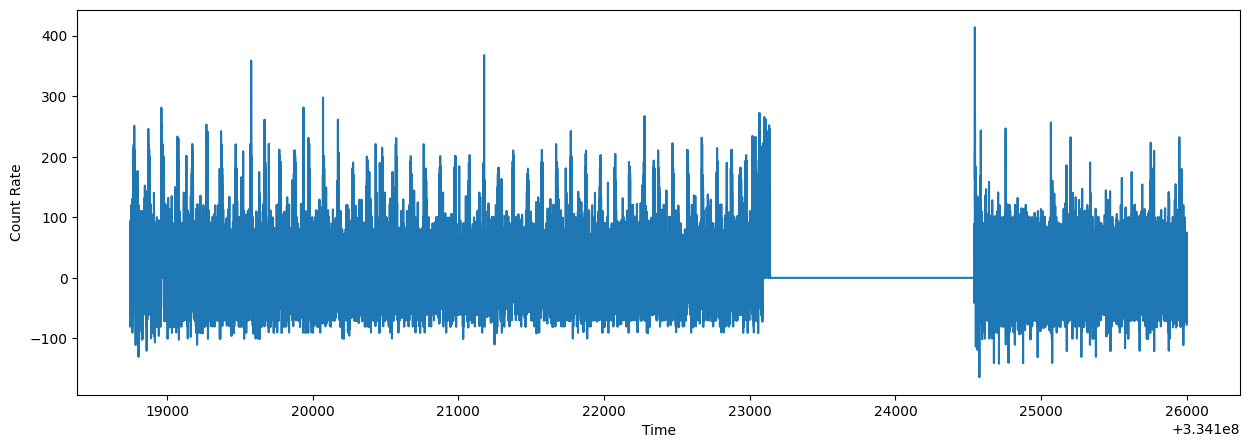

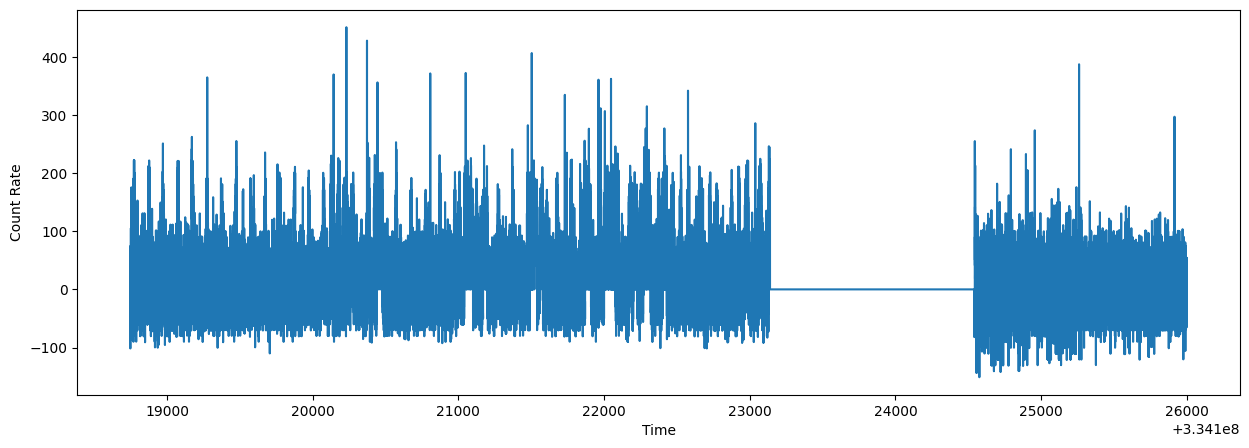

In [6]:

for m in m_complete:
    x = m[1].data['TIME']
    y = m[1].data['RATE']
    c = 33410e4
    intervals = np.arange(24500, 26500, 10)
    median_values = []
    for i in range(len(intervals) - 1):
        indices = np.where((x - c >= intervals[i]) & (x - c < intervals[i + 1]))
        y_interval = y[indices]
        median = np.median(y_interval)
        median_values.append(median)
        y[indices] -= median
    plt.subplots(1, 1, figsize = (15,5))
    #plt.xlim(500+3.0737e8,4100+3.0737e8)
    plt.xlabel("Time")
    plt.ylabel("Count Rate")
    plt.plot(x,y)


#### Calculating SNR using the traditional method:

In [7]:
count = -1
for m in m_complete:
    x = m[1].data['TIME']
    y = m[1].data['RATE']
    count += 1
    indices_range = np.where((x  >= 21650 + c) & (x  <= 21800 + c))
    y_range = y[indices_range]
    mean = np.mean(y_range)
    indices_range1 = np.where((x  <= 21650 + c) &(x>=19000 +c))
    indices_range2 = np.where((x  >= 24800 + c)&(x<=25800 +c))
    add = np.concatenate([y[indices_range2],y[indices_range1]])
    print("The SNR for quad",count,"is",20*np.log10((mean-np.mean(add))/np.std(add)),"dB")
    #print(mean)

The SNR for quad 0 is 0.353047314658761 dB
The SNR for quad 1 is 0.907961332798004 dB
The SNR for quad 2 is 0.1828093522787094 dB
The SNR for quad 3 is 0.2710533618927 dB


### Calculating using Gaussian Modelling:


In [8]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

[5297.45572892  124.42488911   37.15067276]
[1942.98724503  125.22017681   37.23569747]
[1649.62516072  120.0802986    36.20985717]
[2106.87737703  110.68834083   35.38608204]


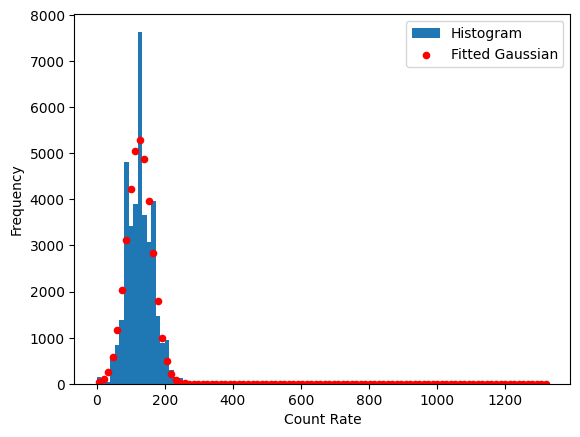

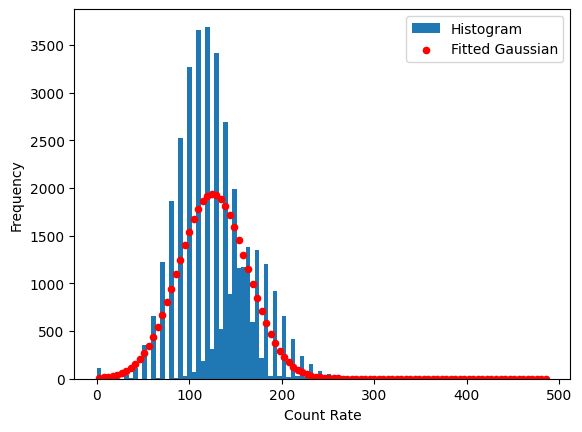

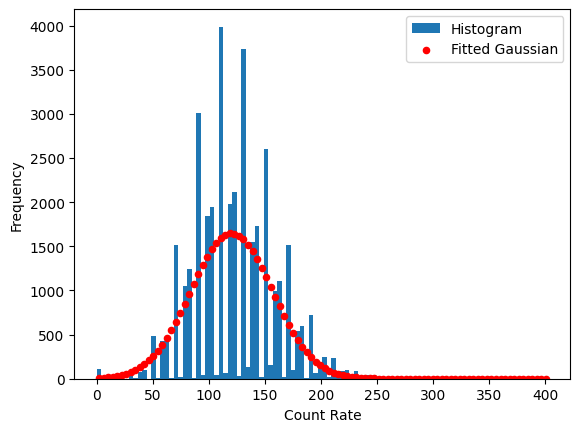

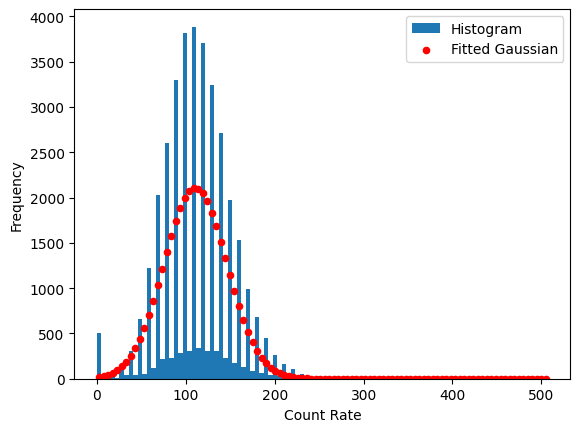

In [9]:
from scipy.optimize import curve_fit
a1=fits.open('final_output_Q0.lc')
a2=fits.open('final_output_Q1.lc')
a3=fits.open('final_output_Q2.lc')
a4=fits.open('final_output_Q3.lc')
amp = []
mean = []
stddev = []


a_complete=[a1,a2,a3,a4]
for a in a_complete:
    x = a[1].data['TIME']
    y = a[1].data['RATE']
    indices_range1 = np.where((x  <= 21650 + c) &(x>=18900 +c))
    indices_range2 = np.where((x  >= 24800 + c)&(x<=25800 +c))
    add = np.concatenate([y[indices_range2],y[indices_range1]])
    hist, bins = np.histogram(add, bins=100, density=False)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    amplitude_guess = np.max(hist)
    mean_guess = np.mean(bin_centers)
    initial_guess = [100, 100, 10]
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
    amplitude_fit, mean_fit, stddev_fit = popt
    curve_x = np.linspace(min(bin_centers), max(bin_centers), 100)
    curve_y = gaussian(curve_x, amplitude_fit, mean_fit, stddev_fit)
    amp.append(amplitude_fit)
    mean.append(mean_fit)
    stddev.append(stddev_fit)

    plt.subplots(1, 1)
    plt.xlabel("Count Rate")
    plt.ylabel("Frequency")
    plt.hist(add,bins = 100, label='Histogram',density=False)
    plt.scatter(curve_x, curve_y, color = 'red', label='Fitted Gaussian',s=20)
    plt.legend()
    print(popt)


In [10]:
def observations(data, mean, std):
    threshold = 3 * std                  #  3 sigma threshold
    lower_bound = mean - threshold
    upper_bound = mean + threshold
    observations_within_3sigma = np.where((data >= lower_bound) & (data <= upper_bound))
    observations_outside_3sigma = np.where((data < lower_bound) | (data > upper_bound))
    return observations_within_3sigma,observations_outside_3sigma

In [16]:
count = 0
noise = [31,12,16,22]
for a in a_complete:
    x = a[1].data['TIME']
    y = a[1].data['RATE']
    maxi = np.max(y)
    indices_range1 = np.where((x  <= 21650 + c) &(x>=18900 +c))
    indices_range2 = np.where((x  >= 24800 + c)&(x<=25800 +c))
    add = np.concatenate([y[indices_range2],y[indices_range1]])
    indices_range = np.where((x  >= 2300 + c) & (x  <= 2500 + c))
    y_range = y[indices_range]
    mean2 = np.mean(y_range)
    obs,out  = observations(add, mean[count], stddev[count])    
    count+=1
    arr = np.array(obs)
    arr2 = np.array(out)
    snr = maxi/(stddev[count-1])
    print("The SNR for quad",count-1,"is",20*log10(snr))
    

The SNR for quad 0 is 0.576993055364062 dB
The SNR for quad 1 is 1.2465338765462695 dB
The SNR for quad 2 is 0.7410504300779461 dB
The SNR for quad 3 is 0.7963181055183933 dB


### Using Savgol filtering:

c:\Users\yashs\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yashs\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


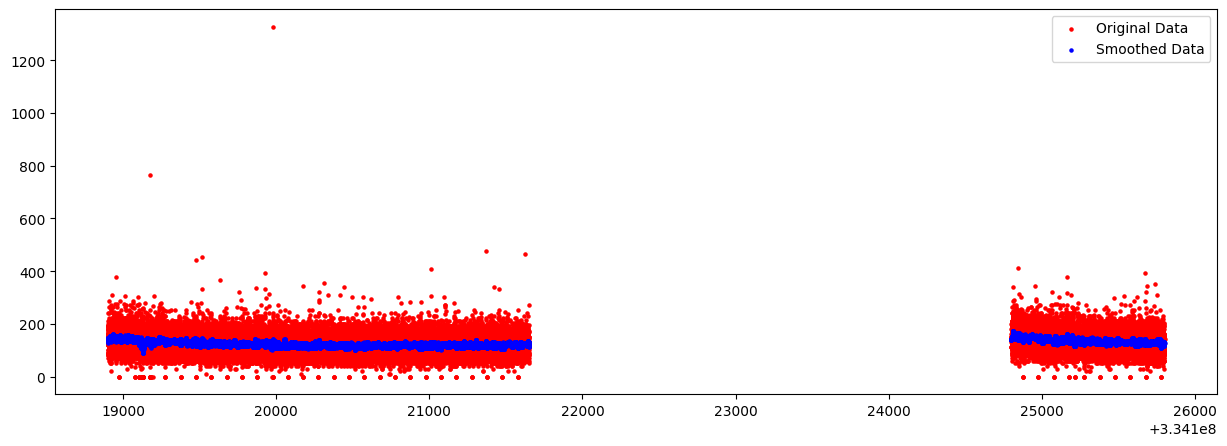

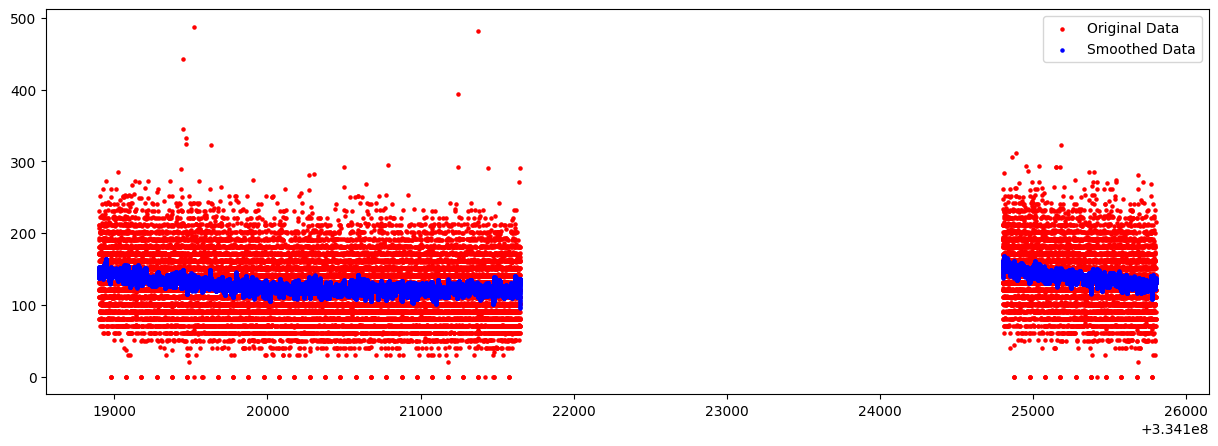

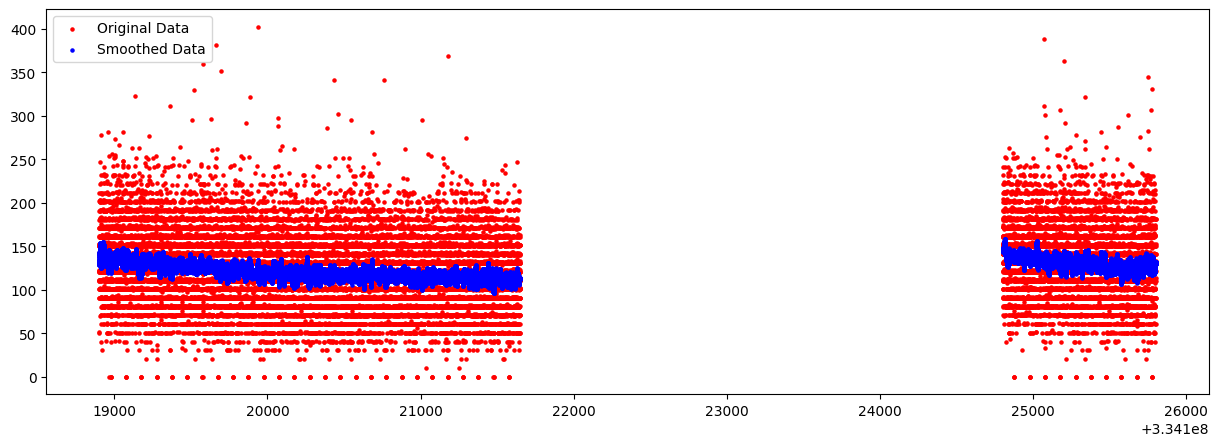

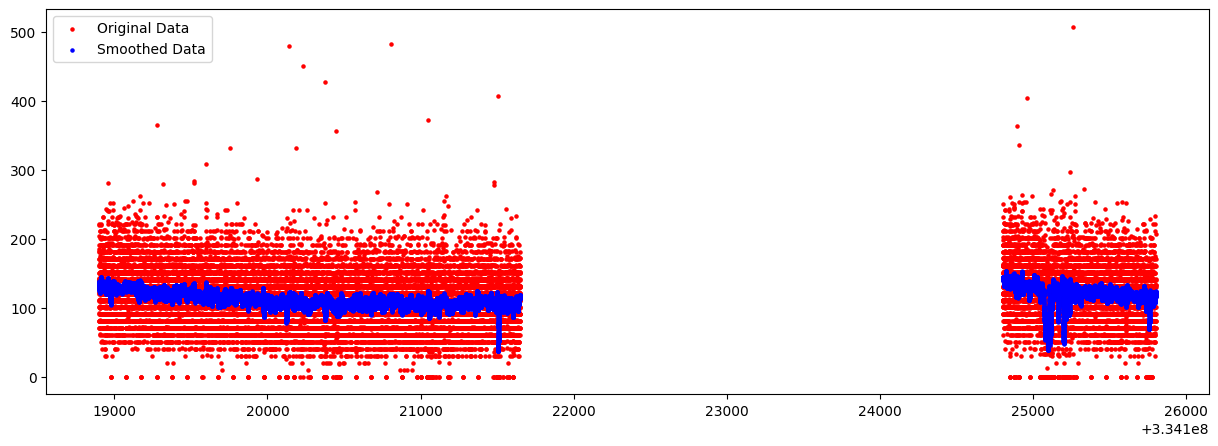

In [17]:
from scipy.signal import savgol_filter
count = 0
for a in a_complete:
    x = a[1].data['TIME']
    y = a[1].data['RATE']
    indices_range1 = np.where((x  <= 21650 + c) &(x>=18900 +c))
    indices_range2 = np.where((x  >= 24800 + c)&(x<=25800 +c))
    add = np.concatenate([y[indices_range2],y[indices_range1]])
    range = np.concatenate([x[indices_range2],x[indices_range1]])
    yhat = savgol_filter(add, 101, 3)
    noise = add-yhat
    signal_mean = np.mean(yhat)
    noise_std= np.std(yhat)
    indices_range = np.where((x  >= 2300 + c) & (x  <= 2600 + c))
    y_range = y[indices_range]
    mean = np.mean(y_range)
    snr = (mean/noise_std)
    plt.subplots(1, 1, figsize = (15,5))
    plt.scatter(range,(add), label = 'Original Data',color = 'red', s = 5)
    plt.scatter(range,yhat, label = 'Smoothed Data', color = 'blue', s = 5)
    plt.legend()
    
    count+=1

## RMS SNR


In [18]:
count = 0
for a in a_complete:
    x = a[1].data['TIME']
    y = a[1].data['RATE']
    indices_range1 = np.where((x  <= 21650 + c) &(x>=18900 +c))
    indices_range2 = np.where((x  >= 24800 + c)&(x<=25800 +c))
    add = np.concatenate([y[indices_range2],y[indices_range1]])
    range = np.concatenate([x[indices_range2],x[indices_range1]])
    signal_sq = np.square(add)
    sq_mean= np.mean(signal_sq)
    rms = np.sqrt(sq_mean)
    indices_range = np.where((x  >= 2300 + c) & (x  <= 2500 + c))
    y_range = y[indices_range]
    mean = np.mean(y_range)
    snr = ((np.max(y) - np.mean(add))/rms)
    print("The SNR for quad",count,"is",((snr)))
    count+=1

The SNR for quad 0 is 0.356946653
The SNR for quad 1 is 1.0105316
The SNR for quad 2 is 0.38529824
The SNR for quad 3 is 0.50655555


c:\Users\yashs\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yashs\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
